# Outlier Detection
This notebook reproduces the outlier detection experiments found in the papers "Joints in Random Forests" and "Towards Robust Classification with Deep Generative Forests".

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import gaussian_kde

from experiments.prep import get_stats, normalize_data, standardize_data, learncats
from gefs.trees import RandomForest

C:\Users\Mennolt van alten\Documents\Data Science - Universiteit\Year 3\BEP\GeFs_Repo\gefs\cluster.py:91: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  ('thr', optional(float64)),
C:\Users\Mennolt van alten\Documents\Data Science - Universiteit\Year 3\BEP\GeFs_Repo\gefs\signed.py:11: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  ('size', int64)
C:\Users\Mennolt van alten\Documents\Data Science - Unive

In [6]:
from scipy.special.cython_special import erfinv
#from scipy.special import erfinv



In [7]:
def train_test(data, ncat, train_ratio=0.7, prep='std'):
    assert train_ratio >= 0
    assert train_ratio <= 1
    shuffle = np.random.choice(range(data.shape[0]), data.shape[0], replace=False)
    data_train = data[shuffle[:int(train_ratio*data.shape[0])], :]
    data_test = data[shuffle[int(train_ratio*data.shape[0]):], :]
    if prep=='norm':
        data_train, maxv, minv, _, _, = get_stats(data_train, ncat)
        X_train, y_train = data_train[:, :-1], data_train[:, -1]
        return X_train, y_train, data_train, data_test, maxv, minv
    elif prep=='std':
        _, maxv, minv, mean, std = get_stats(data_train, ncat)
        data_train = standardize_data(data_train, mean, std)
        X_train, y_train = data_train[:, :-1], data_train[:, -1]
        return X_train, y_train, data_train, data_test, mean, std

## Generative Forests
### White wine model

In [2]:
white = pd.read_csv('data/winequality_white.csv').values
ncat_white = learncats(white, classcol=-1)
ncat_white[-1] = 2

X_train_white, y_train_white, data_train_white, data_test_white, mean_white, std_white = train_test(white, ncat_white, 0.7)
y_train_white = np.where(y_train_white <= 6, 0, 1)

rf_white = RandomForest(n_estimators=100, ncat=ncat_white)
rf_white.fit(X_train_white, y_train_white)
gef_white = rf_white.topc(learnspn=np.Inf)

NameError: name 'train_test' is not defined

### Red wine model

In [9]:
red = pd.read_csv('data/winequality_red.csv').values
ncat_red = learncats(red, classcol=-1)
ncat_red[-1] = 2

X_train_red, y_train_red, data_train_red, data_test_red, mean_red, std_red = train_test(red, ncat_red, 0.7)
y_train_red = np.where(y_train_red <= 6, 0, 1)

rf_red = RandomForest(n_estimators=100, ncat=ncat_red)
rf_red.fit(X_train_red, y_train_red)
gef_red = rf_red.topc(learnspn=np.Inf)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.53it/s]


In [10]:
# The class variable should not be used.
# We set it to NaN so that the PC effectively marginalises it.
data_test_white[:, -1] = np.nan
data_test_red[:, -1] = np.nan

white_by_red = gef_red.log_likelihood(standardize_data(data_test_white, mean_red, std_red))
white_by_white = gef_white.log_likelihood(standardize_data(data_test_white, mean_white, std_white))
red_by_red = gef_red.log_likelihood(standardize_data(data_test_red, mean_red, std_red))
red_by_white = gef_white.log_likelihood(standardize_data(data_test_red, mean_white, std_white))

In [11]:
white_by_red_avg = gef_red.log_likelihood(standardize_data(data_test_white, mean_red, std_red), avg=True)
white_by_white_avg = gef_white.log_likelihood(standardize_data(data_test_white, mean_white, std_white), avg=True)
red_by_red_avg = gef_red.log_likelihood(standardize_data(data_test_red, mean_red, std_red), avg=True)
red_by_white_avg = gef_white.log_likelihood(standardize_data(data_test_red, mean_white, std_white), avg=True)

## Kernel Density Estimator

In [12]:
from sklearn.neighbors import KernelDensity

# We fit one KDE for each dataset and each target variable.
# This is to best match the discriminative behavior of GeFs.
# We then combine the different models using a prior over Y.
# Using a single KDE including the class variable yields very similar results though.

# Red Model Y = 0
kde_red0 = KernelDensity(bandwidth=1., kernel='gaussian')
kde_red0.fit(data_train_red[y_train_red == 0, :-1])

# Red Model Y = 1
kde_red1 = KernelDensity(bandwidth=1., kernel='gaussian')
kde_red1.fit(data_train_red[y_train_red == 1, :-1])

# Compute the priors
p_red0 = len(y_train_red[y_train_red == 0])/len(y_train_red)
p_red1 = len(y_train_red[y_train_red == 1])/len(y_train_red)


# White Model Y = 0
kde_white0 = KernelDensity(bandwidth=1., kernel='gaussian')
kde_white0.fit(data_train_white[y_train_white == 0, :-1])

# Red Model Y = 1
kde_white1 = KernelDensity(bandwidth=1., kernel='gaussian')
kde_white1.fit(data_train_white[y_train_white == 1, :-1])

# Compute the priors
p_white0 = len(y_train_white[y_train_white == 0])/len(y_train_white)
p_white1 = len(y_train_white[y_train_white == 1])/len(y_train_white)

# score_samples returns the log of the probability density
logprob_red_by_red = kde_red0.score_samples(standardize_data(data_test_red, mean_red, std_red)[:, :-1])*p_red0 +\
                     kde_red1.score_samples(standardize_data(data_test_red, mean_red, std_red)[:, :-1])*p_red1

logprob_white_by_red = kde_red0.score_samples(standardize_data(data_test_white, mean_red, std_red)[:, :-1])*p_red0 +\
                       kde_red1.score_samples(standardize_data(data_test_white, mean_red, std_red)[:, :-1])*p_red1

logprob_red_by_white = kde_white0.score_samples(standardize_data(data_test_red, mean_white, std_white)[:, :-1])*p_white0 +\
                       kde_white1.score_samples(standardize_data(data_test_red, mean_white, std_white)[:, :-1])*p_white1

logprob_white_by_white = kde_white0.score_samples(standardize_data(data_test_white, mean_white, std_white)[:, :-1])*p_white0 +\
                         kde_white1.score_samples(standardize_data(data_test_white, mean_white, std_white)[:, :-1])*p_white1


## Maximum Conditional Probability

In [13]:
classcol = data_test_red.shape[1]-1
_, gef_white_by_red_probs = gef_red.classify_avg(standardize_data(data_test_white[:, :-1], mean_red, std_red), classcol=classcol, return_prob=True)
_, gef_white_by_white_probs = gef_white.classify_avg(standardize_data(data_test_white[:, :-1], mean_white, std_white), classcol=classcol, return_prob=True)
_, gef_red_by_red_probs = gef_red.classify_avg(standardize_data(data_test_red[:, :-1], mean_red, std_red), classcol=classcol, return_prob=True)
_, gef_red_by_white_probs = gef_white.classify_avg(standardize_data(data_test_red[:, :-1], mean_white, std_white), classcol=classcol, return_prob=True)

mp_white_by_red = np.max(gef_white_by_red_probs, axis=1)
mp_white_by_white = np.max(gef_white_by_white_probs, axis=1)
mp_red_by_red = np.max(gef_red_by_red_probs, axis=1)
mp_red_by_white = np.max(gef_white_by_red_probs, axis=1)

## ROC AUC Scores

In [14]:
# Combine the two datasets. 
red_white_train = np.concatenate((data_train_red, data_train_white)).copy()
X_train, y_train = red_white_train[:, :-1], red_white_train[:, -1]
y_train = np.where(y_train <= 6, 0, 1)

red_white_test = np.concatenate((data_test_red, data_test_white)).copy()
X_test, y_test = red_white_test[:, :-1], red_white_test[:, -1]
y_train = np.where(y_test <= 6, 0, 1)

red_white = red_white_test.copy()
red_white[:, -1] = np.nan  # We ignore (marginalise over) the target variable
true_red = np.zeros(red_white.shape[0])  # red 1, white 0
true_red[:data_test_red.shape[0]] = 1
true_white = np.ones(red_white.shape[0])  # red 0, white 1
true_white[:data_test_red.shape[0]] = 0

# Predict outliers using GeFs
gef_red_pred = gef_red.log_likelihood(standardize_data(red_white, mean_red, std_red))
gef_white_pred = gef_white.log_likelihood(standardize_data(red_white, mean_white, std_white))

# Predict outliers using KDE
kde_red_pred = kde_red0.score_samples(standardize_data(red_white, mean_red, std_red)[:, :-1])*p_red0 +\
               kde_red1.score_samples(standardize_data(red_white, mean_red, std_red)[:, :-1])*p_red1
kde_white_pred = kde_white0.score_samples(standardize_data(red_white, mean_white, std_white)[:, :-1])*p_white0 +\
                 kde_white1.score_samples(standardize_data(red_white, mean_white, std_white)[:, :-1])*p_white1

# Predict outliers using the maximum conditional probability
_, mp_red_pred = gef_red.classify_avg(standardize_data(red_white, mean_red, std_red), classcol=classcol, return_prob=True)
mp_red_pred = np.max(mp_red_pred, axis=1)
_, mp_white_pred = gef_white.classify_avg(standardize_data(red_white, mean_white, std_white), classcol=classcol, return_prob=True)
mp_white_pred = np.max(mp_white_pred, axis=1)


In [15]:
# Max Conditional Probability Red Model
roc_auc_score(true_red, mp_red_pred)

0.7924121315192744

In [16]:
# Max Conditional Probability White Model
roc_auc_score(true_white, mp_white_pred)

0.4900070861678005

In [17]:
# GeF Red Model
roc_auc_score(true_red, gef_red_pred)

0.9783149092970521

In [18]:
# GeF White Model
roc_auc_score(true_white, gef_white_pred)

0.9860530045351472

In [19]:
# KDE Red Model
roc_auc_score(true_red, kde_red_pred)

0.9814257369614512

In [20]:
# KDE White Model
roc_auc_score(true_white, kde_white_pred)

0.984734977324263

## Plot

C:\Users\Mennolt van alten\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mennolt van alten\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mennolt van alten\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

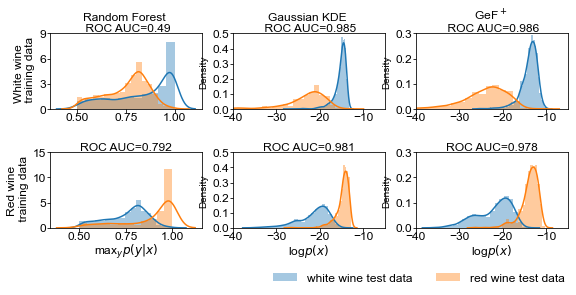

In [21]:
fig, axs = plt.subplots(2, 3, sharey=False, sharex=False)
fig.set_size_inches(w=8., h=3)
labelpad=1
titlepad=1.5

sns.distplot(mp_white_by_white, label='white wine test data', ax=axs[0, 0])
sns.distplot(mp_red_by_white, label='red wine test data', ax=axs[0, 0])
axs[0, 0].set_xticks([.5, .75, 1 ])
axs[0, 0].set_yticks([0, 3, 6, 9])

sns.distplot(logprob_white_by_white, label='white wine test data', ax=axs[0, 1])
sns.distplot(logprob_red_by_white, label='red wine test data', ax=axs[0, 1])
axs[0, 1].set_xticks([-40, -30, -20, -10])
axs[0, 1].set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
axs[0, 1].set_xlim(-40, -5)
axs[0, 1].set_ylim(0, 0.5)

sns.distplot(white_by_white, label='white wine test data', ax=axs[0, 2])
sns.distplot(red_by_white, label='red wine test data', ax=axs[0, 2])
axs[0, 2].set_xticks([-40, -30, -20, -10])
axs[0, 2].set_yticks([0.3, 0.2, 0.1, 0.0])
axs[0, 2].set_xlim(-40, -5)
axs[0, 2].set_ylim(0, 0.3)

sns.distplot(mp_white_by_red, label='white wine test data', ax=axs[1, 0])
sns.distplot(mp_red_by_red, label='red wine test data', ax=axs[1, 0])
axs[1, 0].set_xticks([.5, .75, 1 ])
axs[1, 0].set_yticks([0, 5, 10, 15])

sns.distplot(logprob_white_by_red, label='white wine test data', ax=axs[1, 1])
sns.distplot(logprob_red_by_red, label='red wine test data', ax=axs[1, 1])
axs[1, 1].set_yticks([0., .1, .2, .3, .4, .5])
axs[1, 1].set_xticks([-40, -30, -20, -10])
axs[1, 1].set_xlim(-40, -5)
axs[1, 1].set_ylim(0, 0.5)

sns.distplot(white_by_red, label='white wine test data', ax=axs[1, 2])
sns.distplot(red_by_red, label='red wine test data', ax=axs[1, 2])
axs[1, 2].set_xticks([-40, -30, -20, -10])
axs[1, 2].set_yticks([0.3, 0.2, 0.1, 0.0])
axs[1, 2].set_xlim(-40, -5)
axs[1, 2].set_ylim(0, 0.3)

plt.legend(bbox_to_anchor=(1.05, -.45), ncol=2, frameon=False, fontsize=12)

axs[0, 0].set_title('Random Forest \n ROC AUC=' + str(np.round(roc_auc_score(true_white, mp_white_pred), 3)), fontsize=12, pad=titlepad)
axs[0, 0].set_ylabel('White wine \n training data', fontsize=12)
axs[0, 0].tick_params(axis='both', which='major', pad=.0)
axs[0, 0].xaxis.set_tick_params(labelsize=12)
axs[0, 0].yaxis.set_tick_params(labelsize=12)

axs[0, 1].set_title('Gaussian KDE \n ROC AUC=' + str(np.round(roc_auc_score(true_white, kde_white_pred), 3)), fontsize=12, pad=titlepad)
axs[0, 1].tick_params(axis='both', which='major', pad=.0)
axs[0, 1].xaxis.set_tick_params(labelsize=12)
axs[0, 1].yaxis.set_tick_params(labelsize=12)

axs[0, 2].set_title('GeF$^+$ \n ROC AUC=' + str(np.round(roc_auc_score(true_white, gef_white_pred), 3)), fontsize=12, pad=titlepad)
axs[0, 2].tick_params(axis='both', which='major', pad=.0)
axs[0, 2].xaxis.set_tick_params(labelsize=12)
axs[0, 2].yaxis.set_tick_params(labelsize=12)

axs[1, 0].set_title('ROC AUC=' + str(np.round(roc_auc_score(true_red, mp_red_pred), 3)), fontsize=12, pad=titlepad)
axs[1, 0].set_xlabel('max$_yp(y|x)$', fontsize=12, labelpad=labelpad)
axs[1, 0].set_ylabel('Red wine\n training data', fontsize=12)
axs[1, 0].tick_params(axis='both', which='major', pad=.0)
axs[1, 0].xaxis.set_tick_params(labelsize=12)
axs[1, 0].yaxis.set_tick_params(labelsize=12)

axs[1, 1].set_title('ROC AUC=' + str(np.round(roc_auc_score(true_red, kde_red_pred), 3)), fontsize=12, pad=titlepad)
axs[1, 1].set_xlabel('log$p(x)$', fontsize=12, labelpad=labelpad)
axs[1, 1].tick_params(axis='both', which='major', pad=.0)
axs[1, 1].xaxis.set_tick_params(labelsize=12)
axs[1, 1].yaxis.set_tick_params(labelsize=12)

axs[1, 2].set_title('ROC AUC='  + str(np.round(roc_auc_score(true_red, gef_red_pred), 3)), fontsize=12, pad=titlepad)
axs[1, 2].set_xlabel('log$p(x)$', fontsize=12, labelpad=labelpad)
axs[1, 2].tick_params(axis='both', which='major', pad=0)
axs[1, 2].xaxis.set_tick_params(labelsize=12)
axs[1, 2].yaxis.set_tick_params(labelsize=12)

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=.575, wspace=.2)
sns.set_style("whitegrid")